https://medium.com/distributed-computing-with-ray/anatomy-of-a-custom-environment-for-rllib-327157f269e5 

https://github.com/DerwenAI/gym_example

# Create a custom `gym` environment

Lets first create a simple corridor gym environment.

In [257]:
import gym
from gym.utils import seeding
import numpy as np
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display
from omegaconf import OmegaConf

class DefaultReward:
    def __init__(self,
                 reward_good: float = -1,
                 reward_bad: float = -2):
        self.reward_good = reward_good
        self.reward_bad = reward_bad
    
    def reset(self, env):
        self.prev_agent_pos = env.agent_pos
        
    def extract(self, env):
        if abs(self.prev_agent_pos - env.goal_pos) <= abs(env.agent_pos - env.goal_pos):
            # agent no closer to goal
            reward = self.reward_bad
        else:
            # agent closer to goal
            reward = self.reward_good

        # save agent pos for next step
        self.prev_agent_pos = copy.deepcopy(env.agent_pos)
            
        return reward
        
        

class CorridorEnv(gym.Env):
    def __init__(self,
                 name: str = 'corridor',
                 left_end: int = 1,
                 right_end: int = 10,
                 reward_function: str = 'default'):
        self.name = name
        self.left_end = left_end
        self.right_end = right_end
        self.reward_function_str = reward_function
        
        # action space
        self.action_set = np.array([0, 1]) # move left (0) or right (1)
        self.action_space = gym.spaces.Discrete(len(self.action_set))
                
        # obs space
        self.corridor = np.arange(self.left_end, self.right_end + 1)
        self.observation_space = gym.spaces.Dict({
            'state': gym.spaces.Box(low=self.left_end, high=self.right_end, shape=(1,)),
            'action_set': gym.spaces.Box(low=0, high=1, shape=self.action_set.shape)
        })
        
        # reward function
        if self.reward_function_str == 'default':
            self.reward_function = DefaultReward()
        else:
            raise Exception(f'Unrecognised reward function {self.reward_function_str}')
        
    def reset(self):
#         self.agent_pos = np.random.choice(self.corridor)
#         self.goal_pos = np.random.choice(np.delete(self.corridor, np.where(self.corridor == self.agent_pos)))
        self.agent_pos = 10
        self.goal_pos = 1
        self.reward_function.reset(self)
        self.step_counter = 0
        
        return self.extract_obs()
    
    def extract_obs(self):
        return {'state': np.array([self.agent_pos]),
                'action_set': self.action_set}
    
    def extract_info(self):
        return {'distance_to_goal': abs(self.agent_pos - self.goal_pos)}
        
    def is_done(self):
        return self.agent_pos == self.goal_pos
    
    def seed(self, seed: int = None):
        np.random.seed(seed)
        
    def step(self, action):
        if action == 0:
            if self.agent_pos - 1 >= self.left_end:
                # move left
                self.agent_pos -= 1
            else:
                # invalid movement
                pass
        elif action == 1:
            if self.agent_pos + 1 <= self.right_end:
                # move right
                self.agent_pos += 1
            else:
                # invalid movement
                pass
        else:
            raise Exception(f'Unrecognised action {action}')
            
        obs = self.extract_obs()
        reward = self.reward_function.extract(self)
        done = self.is_done()
        info = self.extract_info()
        
        self.step_counter += 1
        
        return obs, reward, done, info
        
    def render(self):
        img = [0 for _ in range(len(self.corridor))]
        img[int(np.where(self.corridor == self.goal_pos)[0])] = 'G'
        img[int(np.where(self.corridor == self.agent_pos)[0])] = 'A'
        print(img)

# Establish a random agent baseline

Lets now establish a simple random agent baseline for our corridor environment

In [258]:
class RandomAgent:
    def __init__(self,
                 name: str = 'Random'):
        self.name = name
        
    def select_action(self, obs):
        return np.random.choice(obs['action_set'])

Now lets create function to run an agent in this environment until episode terminates

In [259]:
def run_episode(env, agent):
    episode_stats = defaultdict(lambda: 0)
    episode_stats['agent'] = agent.name
    obs = env.reset()
    agent = RandomAgent()
    done = False
    while not done:
        action = agent.select_action(obs)
        prev_obs = copy.deepcopy(obs) # save
        obs, reward, done, info = env.step(action)
#         print(f'\nStep {env.step_counter} | Obs: {prev_obs} | Action: {action} | Next obs: {obs} | Reward: {reward} | Info: {info}')
#         env.render()
        
        # record stats
        episode_stats['episode_reward'] += reward
        episode_stats['episode_lengths'] += 1
        
    return episode_stats

Establish a baseline for the random agent

In [260]:
seeds = [0, 1, 2]
num_episodes = 1000
random_baseline_stats = defaultdict(lambda: [])

env = CorridorEnv()
agent = RandomAgent()
for seed in seeds:
    print(f'\n\n\n------ Seed {seed} ------')
    np.random.seed(seed)
    for episode_counter in range(num_episodes):
        episode_stats = run_episode(env, agent)
        episode_stats['seed'] = seed
        print(f'Episode {episode_counter+1} stats:\n{episode_stats}')
        
        for key, val in episode_stats.items():
            random_baseline_stats[key].append(val)
            
display(pd.DataFrame(random_baseline_stats))




------ Seed 0 ------
Episode 1 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7fd98077c9d0>, {'agent': 'Random', 'episode_reward': -288, 'episode_lengths': 190, 'seed': 0})
Episode 2 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7fd98077c940>, {'agent': 'Random', 'episode_reward': -35, 'episode_lengths': 26, 'seed': 0})
Episode 3 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7fd98077c820>, {'agent': 'Random', 'episode_reward': -381, 'episode_lengths': 246, 'seed': 0})
Episode 4 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7fd98077c940>, {'agent': 'Random', 'episode_reward': -128, 'episode_lengths': 87, 'seed': 0})
Episode 5 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7fd98077c820>, {'agent': 'Random', 'episode_reward': -80, 'episode_lengths': 53, 'seed': 0})
Episode 6 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7fd98077c9d0>, {'agent': 'Random', 'episode_reward': -228, 'ep

Episode 125 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -336, 'episode_lengths': 220, 'seed': 0})
Episode 126 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -159, 'episode_lengths': 108, 'seed': 0})
Episode 127 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -15, 'episode_lengths': 13, 'seed': 0})
Episode 128 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -86, 'episode_lengths': 59, 'seed': 0})
Episode 129 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -175, 'episode_lengths': 117, 'seed': 0})
Episode 130 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -103, 'episode_lengt

defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -409, 'episode_lengths': 267, 'seed': 0})
Episode 242 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -212, 'episode_lengths': 138, 'seed': 0})
Episode 243 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -26, 'episode_lengths': 20, 'seed': 0})
Episode 244 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -299, 'episode_lengths': 198, 'seed': 0})
Episode 245 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -69, 'episode_lengths': 45, 'seed': 0})
Episode 246 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -181, 'episode_lengths': 119, 'seed': 0

Episode 346 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -349, 'episode_lengths': 229, 'seed': 0})
Episode 347 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -62, 'episode_lengths': 41, 'seed': 0})
Episode 348 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -220, 'episode_lengths': 142, 'seed': 0})
Episode 349 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -335, 'episode_lengths': 219, 'seed': 0})
Episode 350 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -174, 'episode_lengths': 117, 'seed': 0})
Episode 351 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -221, 'episode_len

Episode 442 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -126, 'episode_lengths': 85, 'seed': 0})
Episode 443 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -311, 'episode_lengths': 204, 'seed': 0})
Episode 444 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -48, 'episode_lengths': 33, 'seed': 0})
Episode 445 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -26, 'episode_lengths': 20, 'seed': 0})
Episode 446 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -391, 'episode_lengths': 258, 'seed': 0})
Episode 447 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -21, 'episode_lengths

Episode 553 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -81, 'episode_lengths': 57, 'seed': 0})
Episode 554 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -206, 'episode_lengths': 129, 'seed': 0})
Episode 555 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -24, 'episode_lengths': 19, 'seed': 0})
Episode 556 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -149, 'episode_lengths': 101, 'seed': 0})
Episode 557 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -18, 'episode_lengths': 15, 'seed': 0})
Episode 558 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -174, 'episode_lengths

Episode 673 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -88, 'episode_lengths': 60, 'seed': 0})
Episode 674 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -188, 'episode_lengths': 124, 'seed': 0})
Episode 675 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -12, 'episode_lengths': 11, 'seed': 0})
Episode 676 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -250, 'episode_lengths': 163, 'seed': 0})
Episode 677 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -143, 'episode_lengths': 98, 'seed': 0})
Episode 678 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -145, 'episode_length

Episode 760 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -579, 'episode_lengths': 377, 'seed': 0})
Episode 761 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a790>, {'agent': 'Random', 'episode_reward': -147, 'episode_lengths': 98, 'seed': 0})
Episode 762 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -96, 'episode_lengths': 63, 'seed': 0})
Episode 763 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -167, 'episode_lengths': 109, 'seed': 0})
Episode 764 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a790>, {'agent': 'Random', 'episode_reward': -214, 'episode_lengths': 139, 'seed': 0})
Episode 765 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -207, 'episode_leng

Episode 838 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -166, 'episode_lengths': 106, 'seed': 0})
Episode 839 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -35, 'episode_lengths': 25, 'seed': 0})
Episode 840 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -81, 'episode_lengths': 56, 'seed': 0})
Episode 841 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -63, 'episode_lengths': 44, 'seed': 0})
Episode 842 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -196, 'episode_lengths': 130, 'seed': 0})
Episode 843 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -159, 'episode_lengths

Episode 928 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -340, 'episode_lengths': 220, 'seed': 0})
Episode 929 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -46, 'episode_lengths': 32, 'seed': 0})
Episode 930 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -36, 'episode_lengths': 25, 'seed': 0})
Episode 931 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a790>, {'agent': 'Random', 'episode_reward': -154, 'episode_lengths': 104, 'seed': 0})
Episode 932 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -527, 'episode_lengths': 346, 'seed': 0})
Episode 933 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -452, 'episode_lengt

Episode 34 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -268, 'episode_lengths': 178, 'seed': 1})
Episode 35 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -115, 'episode_lengths': 79, 'seed': 1})
Episode 36 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -178, 'episode_lengths': 120, 'seed': 1})
Episode 37 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -66, 'episode_lengths': 45, 'seed': 1})
Episode 38 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -120, 'episode_lengths': 81, 'seed': 1})
Episode 39 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -100, 'episode_lengths': 6

Episode 132 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -21, 'episode_lengths': 17, 'seed': 1})
Episode 133 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -132, 'episode_lengths': 86, 'seed': 1})
Episode 134 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -386, 'episode_lengths': 250, 'seed': 1})
Episode 135 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -121, 'episode_lengths': 78, 'seed': 1})
Episode 136 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -179, 'episode_lengths': 118, 'seed': 1})
Episode 137 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -175, 'episode_lengt

Episode 244 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -236, 'episode_lengths': 155, 'seed': 1})
Episode 245 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -285, 'episode_lengths': 189, 'seed': 1})
Episode 246 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -12, 'episode_lengths': 11, 'seed': 1})
Episode 247 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -228, 'episode_lengths': 150, 'seed': 1})
Episode 248 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -88, 'episode_lengths': 60, 'seed': 1})
Episode 249 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -253, 'episode_lengt

Episode 341 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -189, 'episode_lengths': 126, 'seed': 1})
Episode 342 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -191, 'episode_lengths': 128, 'seed': 1})
Episode 343 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -42, 'episode_lengths': 31, 'seed': 1})
Episode 344 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -58, 'episode_lengths': 40, 'seed': 1})
Episode 345 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -234, 'episode_lengths': 154, 'seed': 1})
Episode 346 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -136, 'episode_lengt

Episode 443 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -280, 'episode_lengths': 184, 'seed': 1})
Episode 444 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -78, 'episode_lengths': 53, 'seed': 1})
Episode 445 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -194, 'episode_lengths': 128, 'seed': 1})
Episode 446 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -50, 'episode_lengths': 36, 'seed': 1})
Episode 447 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -120, 'episode_lengths': 79, 'seed': 1})
Episode 448 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -52, 'episode_lengths

Episode 546 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -168, 'episode_lengths': 114, 'seed': 1})
Episode 547 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -221, 'episode_lengths': 146, 'seed': 1})
Episode 548 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -88, 'episode_lengths': 61, 'seed': 1})
Episode 549 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -170, 'episode_lengths': 112, 'seed': 1})
Episode 550 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -77, 'episode_lengths': 53, 'seed': 1})
Episode 551 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -195, 'episode_lengt

Episode 669 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -280, 'episode_lengths': 183, 'seed': 1})
Episode 670 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -69, 'episode_lengths': 48, 'seed': 1})
Episode 671 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -21, 'episode_lengths': 17, 'seed': 1})
Episode 672 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -246, 'episode_lengths': 165, 'seed': 1})
Episode 673 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -47, 'episode_lengths': 34, 'seed': 1})
Episode 674 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -54, 'episode_lengths'

Episode 805 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -199, 'episode_lengths': 135, 'seed': 1})
Episode 806 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -104, 'episode_lengths': 71, 'seed': 1})
Episode 807 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -14, 'episode_lengths': 12, 'seed': 1})
Episode 808 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -262, 'episode_lengths': 174, 'seed': 1})
Episode 809 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -140, 'episode_lengths': 93, 'seed': 1})
Episode 810 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -58, 'episode_length

Episode 917 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a9d0>, {'agent': 'Random', 'episode_reward': -237, 'episode_lengths': 156, 'seed': 1})
Episode 918 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -226, 'episode_lengths': 149, 'seed': 1})
Episode 919 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -15, 'episode_lengths': 13, 'seed': 1})
Episode 920 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a9d0>, {'agent': 'Random', 'episode_reward': -112, 'episode_lengths': 71, 'seed': 1})
Episode 921 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -84, 'episode_lengths': 57, 'seed': 1})
Episode 922 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -175, 'episode_length

Episode 28 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37ab80>, {'agent': 'Random', 'episode_reward': -380, 'episode_lengths': 250, 'seed': 2})
Episode 29 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -40, 'episode_lengths': 28, 'seed': 2})
Episode 30 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -161, 'episode_lengths': 105, 'seed': 2})
Episode 31 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37ab80>, {'agent': 'Random', 'episode_reward': -119, 'episode_lengths': 82, 'seed': 2})
Episode 32 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -155, 'episode_lengths': 102, 'seed': 2})
Episode 33 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -183, 'episode_lengths': 

Episode 140 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -88, 'episode_lengths': 59, 'seed': 2})
Episode 141 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a9d0>, {'agent': 'Random', 'episode_reward': -31, 'episode_lengths': 23, 'seed': 2})
Episode 142 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37ab80>, {'agent': 'Random', 'episode_reward': -71, 'episode_lengths': 50, 'seed': 2})
Episode 143 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -107, 'episode_lengths': 71, 'seed': 2})
Episode 144 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a9d0>, {'agent': 'Random', 'episode_reward': -528, 'episode_lengths': 347, 'seed': 2})
Episode 145 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37ab80>, {'agent': 'Random', 'episode_reward': -93, 'episode_lengths':

Episode 247 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -225, 'episode_lengths': 146, 'seed': 2})
Episode 248 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37ab80>, {'agent': 'Random', 'episode_reward': -130, 'episode_lengths': 85, 'seed': 2})
Episode 249 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -134, 'episode_lengths': 88, 'seed': 2})
Episode 250 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -179, 'episode_lengths': 118, 'seed': 2})
Episode 251 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37ab80>, {'agent': 'Random', 'episode_reward': -191, 'episode_lengths': 125, 'seed': 2})
Episode 252 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -309, 'episode_len

Episode 352 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -131, 'episode_lengths': 90, 'seed': 2})
Episode 353 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -241, 'episode_lengths': 157, 'seed': 2})
Episode 354 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -39, 'episode_lengths': 29, 'seed': 2})
Episode 355 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -22, 'episode_lengths': 17, 'seed': 2})
Episode 356 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -77, 'episode_lengths': 53, 'seed': 2})
Episode 357 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -35, 'episode_lengths':

Episode 477 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -56, 'episode_lengths': 40, 'seed': 2})
Episode 478 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37ab80>, {'agent': 'Random', 'episode_reward': -109, 'episode_lengths': 75, 'seed': 2})
Episode 479 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -43, 'episode_lengths': 31, 'seed': 2})
Episode 480 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -21, 'episode_lengths': 17, 'seed': 2})
Episode 481 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37ab80>, {'agent': 'Random', 'episode_reward': -194, 'episode_lengths': 128, 'seed': 2})
Episode 482 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -187, 'episode_lengths'

Episode 592 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -107, 'episode_lengths': 72, 'seed': 2})
Episode 593 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -164, 'episode_lengths': 109, 'seed': 2})
Episode 594 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -29, 'episode_lengths': 22, 'seed': 2})
Episode 595 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -131, 'episode_lengths': 85, 'seed': 2})
Episode 596 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -213, 'episode_lengths': 140, 'seed': 2})
Episode 597 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a820>, {'agent': 'Random', 'episode_reward': -115, 'episode_lengt

Episode 692 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -215, 'episode_lengths': 144, 'seed': 2})
Episode 693 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -47, 'episode_lengths': 34, 'seed': 2})
Episode 694 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -246, 'episode_lengths': 165, 'seed': 2})
Episode 695 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -121, 'episode_lengths': 81, 'seed': 2})
Episode 696 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -83, 'episode_lengths': 56, 'seed': 2})
Episode 697 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -36, 'episode_lengths

Episode 784 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37ab80>, {'agent': 'Random', 'episode_reward': -97, 'episode_lengths': 66, 'seed': 2})
Episode 785 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -64, 'episode_lengths': 45, 'seed': 2})
Episode 786 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -353, 'episode_lengths': 233, 'seed': 2})
Episode 787 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37ab80>, {'agent': 'Random', 'episode_reward': -299, 'episode_lengths': 195, 'seed': 2})
Episode 788 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -358, 'episode_lengths': 231, 'seed': 2})
Episode 789 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a5e0>, {'agent': 'Random', 'episode_reward': -43, 'episode_length

Episode 878 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -408, 'episode_lengths': 271, 'seed': 2})
Episode 879 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -150, 'episode_lengths': 99, 'seed': 2})
Episode 880 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -90, 'episode_lengths': 63, 'seed': 2})
Episode 881 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a550>, {'agent': 'Random', 'episode_reward': -45, 'episode_lengths': 30, 'seed': 2})
Episode 882 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aca0>, {'agent': 'Random', 'episode_reward': -35, 'episode_lengths': 26, 'seed': 2})
Episode 883 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a040>, {'agent': 'Random', 'episode_reward': -72, 'episode_lengths':

defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37aaf0>, {'agent': 'Random', 'episode_reward': -329, 'episode_lengths': 216, 'seed': 2})
Episode 968 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -47, 'episode_lengths': 34, 'seed': 2})
Episode 969 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -74, 'episode_lengths': 51, 'seed': 2})
Episode 970 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -153, 'episode_lengths': 103, 'seed': 2})
Episode 971 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a0d0>, {'agent': 'Random', 'episode_reward': -80, 'episode_lengths': 55, 'seed': 2})
Episode 972 stats:
defaultdict(<function run_episode.<locals>.<lambda> at 0x7faabc37a280>, {'agent': 'Random', 'episode_reward': -893, 'episode_lengths': 586, 'seed': 2})

,agent,episode_reward,episode_lengths,seed
0,Random,-288,190,0
1,Random,-35,26,0
2,Random,-381,246,0
3,Random,-128,87,0
4,Random,-80,53,0
...,...,...,...,...
2995,Random,-128,86,2
2996,Random,-835,537,2
2997,Random,-390,253,2
2998,Random,-102,69,2


# Create a custom `rllib` agent with a custom `torch` approximator

### 1. Register the custom environment with `ray`

To make our custom corridor environment easy to use with `ray`, lets register it with `ray`

In [261]:
from ray.tune.registry import register_env

register_env('corridor', lambda env_config: CorridorEnv(**env_config))

### 2. Define and register a custom torch model approximator

First lets create a custom RLLib policy approximated by a Torch model 

In [262]:
import torch
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork as TorchFC

class TorchCustomModel(TorchModelV2, torch.nn.Module):
    """Example of a PyTorch custom model that just delegates to a fc-net."""

    def __init__(self, 
                 obs_space, 
                 action_space, 
                 num_outputs, 
                 model_config, 
                 name):
        TorchModelV2.__init__(
            self, 
            obs_space, 
            action_space, 
            num_outputs, 
            model_config, 
            name
        )
        
        torch.nn.Module.__init__(self)

        self.torch_sub_model = TorchFC(
            obs_space, 
            action_space, 
            num_outputs, 
            model_config, 
            name
        )
        
    def _process_input_dict(self, input_dict):
        if isinstance(input_dict['obs'], dict):
            # concatenate
            input_dict['obs'] = torch.hstack([input_dict['obs'][key].float() for key in input_dict['obs'].keys()])
        else:
            input_dict['obs'] = input_dict['obs'].float()
        return input_dict

    def forward(self, 
                input_dict, 
                state, 
                seq_lens):
        # process obs ready for forward pass
        input_dict = self._process_input_dict(input_dict)
#         print(f'input_dict obs:\n{type(input_dict["obs"])}\n{input_dict["obs"].shape}\n{input_dict["obs"]}')
            
        # perform forward pass
        fc_out, _ = self.torch_sub_model(input_dict, state, seq_lens)
        
        return fc_out, []

    def value_function(self):
        return torch.reshape(self.torch_sub_model.value_function(), [-1])

We now need to register our custom model with `rllib`

In [263]:
from ray.rllib.models import ModelCatalog

ModelCatalog.register_custom_model('my_model', TorchCustomModel)

### 3. Define any hyperparameters using `rllib` config protocol and initialise `rllib` trainer

Lets write a `config.yaml` in a separate file following the `rllib` config protocol and load it here

In [264]:
# load config
config = OmegaConf.load('configs/corridor_rllib.yaml')
print(OmegaConf.to_yaml(config))

# convert config to dict so that is comparible with rllib
config = OmegaConf.to_container(config, resolve=False)

seed: 0
env: corridor
env_config:
  name: corridor
  left_end: 1
  right_end: 10
  reward_function: default
model:
  custom_model: my_model
  vf_share_layers: true
lr: 0.001
num_gpus: 1
num_workers: 1
framework: torch



Lets consider that we want to train our policy using PPO. As recommended by the docs, lets merge our config with the default RLLib `ppo` config

In [265]:
from ray.rllib.agents import ppo

# load default PPO config and update with custom config params
ppo_config = ppo.DEFAULT_CONFIG.copy()
ppo_config.update(config)
print(f'Config:\n{ppo_config}')

# initialise rllib trainer
trainer = ppo.PPOTrainer(config=ppo_config)
print('\nInitialised trainer.')

Config:
{'num_workers': 1, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 200, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.001, 'train_batch_size': 4000, 'model': {'custom_model': 'my_model', 'vf_share_layers': True}, 'optimizer': {}, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env': 'corridor', 'observation_space': None, 'action_space': None, 'env_config': {'name': 'corridor', 'left_end': 1, 'right_end': 10, 'reward_function': 'default'}, 'remote_worker_envs': False, 'remote_env_batch_wait_ms': 0, 'env_task_fn': None, 'render_env': False, 'record_env': False, 'clip_rewards': None, 'normalize_actions': True, 'clip_actions': False, 'preprocessor_pref': 'deepmind', 'log_level': 'WARN', 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>, 'ignore_worker_failures': False, 'log_sys_usage': True, 'fake_sampler': False, 'framework': 'torch', 'eager_tracing': False, 'eager_max_retraces': 20, 'explore': True

2022-04-11 19:57:09,135	WARNING util.py:55 -- Install gputil for GPU system monitoring.



Initialised trainer.


# Train the agent on the custom gym env

In [266]:
from ray.tune.logger import pretty_print


agent_name = 'PPO'
num_epochs = 20
rl_training_stats = defaultdict(lambda: [])
for epoch in range(num_epochs):
    print(f'\n------- Epoch {epoch+1} of {num_epochs} -------')
    result = trainer.train()
    
    # print epoch data
    print(pretty_print(result))
    
    # save epoch data
    for key, val in result['hist_stats'].items():
        rl_training_stats[key].extend(val)
    for _ in range(len(val)):
        rl_training_stats['seed'].append(result['config']['seed'])
        rl_training_stats['agent'].append(agent_name)
        rl_training_stats['epoch'].append(epoch)
        
display(pd.DataFrame(rl_training_stats))


------- Epoch 1 of 20 -------


2022-04-11 19:57:19,958	WARNING ppo.py:148 -- The magnitude of your value function loss is extremely large (3841.017015321793) compared to the policy loss (-0.01738621133469766). This can prevent the policy from learning. Consider scaling down the VF loss by reducing vf_loss_coeff, or disabling vf_share_layers.


agent_timesteps_total: 4000
custom_metrics: {}
date: 2022-04-11_19-57-19
done: false
episode_len_mean: 104.3157894736842
episode_media: {}
episode_reward_max: -15.0
episode_reward_mean: -156.76315789473685
episode_reward_min: -898.0
episodes_this_iter: 38
episodes_total: 38
experiment_id: 5aeee37c902c4487995f53e31148d1e2
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      learner_stats:
        cur_kl_coeff: 0.20000000000000004
        cur_lr: 0.0010000000000000005
        entropy: 0.6658365451520489
        entropy_coeff: 0.0
        kl: 0.028567365574128162
        policy_loss: -0.01738621133469766
        total_loss: 3841.005361085297
        vf_explained_var: 0.00015772683646089286
        vf_loss: 3841.017015321793
  num_agent_steps_sampled: 4000
  num_agent_steps_trained: 4000
  num_steps_sampled: 4000
  num_steps_trained: 4000
  num_steps_trained_this_iter: 4000
iterations_since_restore: 1
node_ip: 128.40.41.23
num_healthy_workers: 1
off_policy_estimator: {

2022-04-11 19:57:30,409	WARNING ppo.py:148 -- The magnitude of your value function loss is extremely large (204.08368533144716) compared to the policy loss (-0.05151956120245559). This can prevent the policy from learning. Consider scaling down the VF loss by reducing vf_loss_coeff, or disabling vf_share_layers.


agent_timesteps_total: 8000
custom_metrics: {}
date: 2022-04-11_19-57-30
done: false
episode_len_mean: 27.226027397260275
episode_media: {}
episode_reward_max: -9.0
episode_reward_mean: -36.986301369863014
episode_reward_min: -157.0
episodes_this_iter: 146
episodes_total: 184
experiment_id: 5aeee37c902c4487995f53e31148d1e2
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      learner_stats:
        cur_kl_coeff: 0.3
        cur_lr: 0.0010000000000000005
        entropy: 0.542034359324363
        entropy_coeff: 0.0
        kl: 0.040954446351546304
        policy_loss: -0.05151956120245559
        total_loss: 204.04445224474836
        vf_explained_var: 0.26312917092795013
        vf_loss: 204.08368533144716
  num_agent_steps_sampled: 8000
  num_agent_steps_trained: 8000
  num_steps_sampled: 8000
  num_steps_trained: 8000
  num_steps_trained_this_iter: 4000
iterations_since_restore: 2
node_ip: 128.40.41.23
num_healthy_workers: 1
off_policy_estimator: {}
perf:
  cpu_ut

agent_timesteps_total: 28000
custom_metrics: {}
date: 2022-04-11_19-58-23
done: false
episode_len_mean: 9.803921568627452
episode_media: {}
episode_reward_max: -9.0
episode_reward_mean: -10.242647058823529
episode_reward_min: -21.0
episodes_this_iter: 408
episodes_total: 1914
experiment_id: 5aeee37c902c4487995f53e31148d1e2
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      learner_stats:
        cur_kl_coeff: 0.6750000000000002
        cur_lr: 0.0010000000000000005
        entropy: 0.1261635549086076
        entropy_coeff: 0.0
        kl: 0.004761850158468478
        policy_loss: -0.030698203567856103
        total_loss: 2.1508824741087293
        vf_explained_var: 0.8197157329128635
        vf_loss: 2.178366431722077
  num_agent_steps_sampled: 28000
  num_agent_steps_trained: 28000
  num_steps_sampled: 28000
  num_steps_trained: 28000
  num_steps_trained_this_iter: 4000
iterations_since_restore: 7
node_ip: 128.40.41.23
num_healthy_workers: 1
off_policy_estimator

agent_timesteps_total: 48000
custom_metrics: {}
date: 2022-04-11_19-59-16
done: false
episode_len_mean: 9.004504504504505
episode_media: {}
episode_reward_max: -9.0
episode_reward_mean: -9.006756756756756
episode_reward_min: -12.0
episodes_this_iter: 444
episodes_total: 4108
experiment_id: 5aeee37c902c4487995f53e31148d1e2
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      learner_stats:
        cur_kl_coeff: 0.04218750000000001
        cur_lr: 0.0010000000000000005
        entropy: 9.48264078999422e-05
        entropy_coeff: 0.0
        kl: 0.005185983582616267
        policy_loss: -0.0017330846699175014
        total_loss: 0.00930405480646959
        vf_explained_var: 0.9985357072404636
        vf_loss: 0.010818358438943874
  num_agent_steps_sampled: 48000
  num_agent_steps_trained: 48000
  num_steps_sampled: 48000
  num_steps_trained: 48000
  num_steps_trained_this_iter: 4000
iterations_since_restore: 12
node_ip: 128.40.41.23
num_healthy_workers: 1
off_policy_e

agent_timesteps_total: 68000
custom_metrics: {}
date: 2022-04-11_20-00-09
done: false
episode_len_mean: 9.0
episode_media: {}
episode_reward_max: -9.0
episode_reward_mean: -9.0
episode_reward_min: -9.0
episodes_this_iter: 445
episodes_total: 6331
experiment_id: 5aeee37c902c4487995f53e31148d1e2
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      learner_stats:
        cur_kl_coeff: 0.0026367187500000006
        cur_lr: 0.0010000000000000005
        entropy: 1.1869193352590286e-06
        entropy_coeff: 0.0
        kl: -9.608566704275563e-15
        policy_loss: 2.3696329369540176e-06
        total_loss: 2.3696329369540176e-06
        vf_explained_var: 1.0
        vf_loss: 1.2174425147812813e-13
  num_agent_steps_sampled: 68000
  num_agent_steps_trained: 68000
  num_steps_sampled: 68000
  num_steps_trained: 68000
  num_steps_trained_this_iter: 4000
iterations_since_restore: 17
node_ip: 128.40.41.23
num_healthy_workers: 1
off_policy_estimator: {}
perf:
  cpu_util_per

,episode_reward,episode_lengths,seed,agent,epoch
0,-289.0,193,0,PPO,0
1,-313.0,201,0,PPO,0
2,-94.0,64,0,PPO,0
3,-116.0,77,0,PPO,0
4,-69.0,46,0,PPO,0
...,...,...,...,...,...
7659,-9.0,9,0,PPO,19
7660,-9.0,9,0,PPO,19
7661,-9.0,9,0,PPO,19
7662,-9.0,9,0,PPO,19


Plotting metric episode_lengths


<Figure size 1920x1440 with 0 Axes>

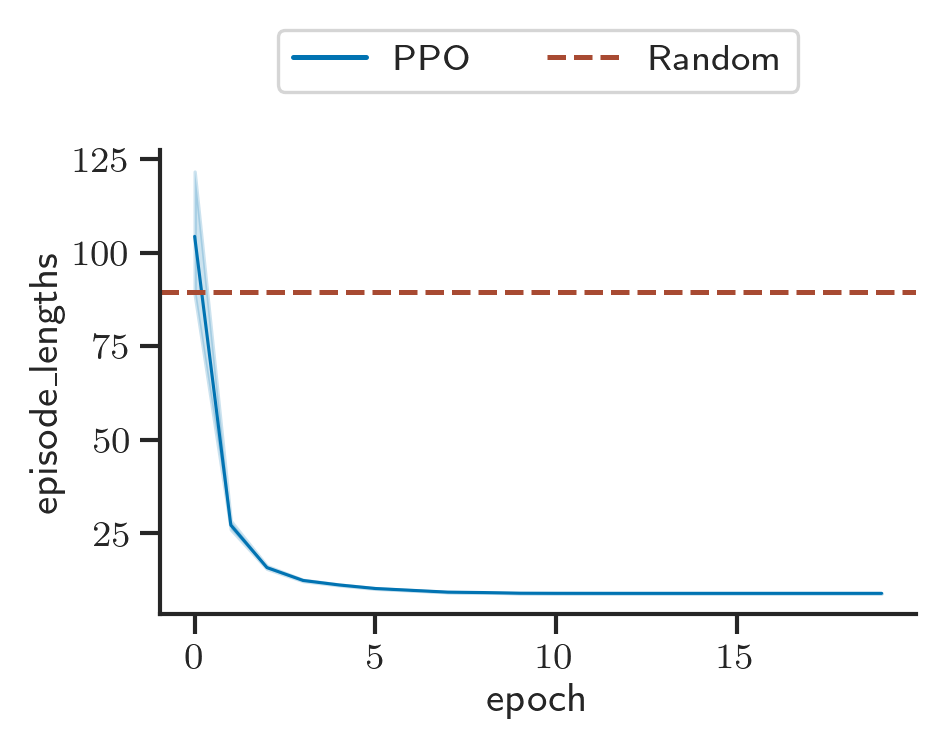

Plotting metric episode_reward


<Figure size 1920x1440 with 0 Axes>

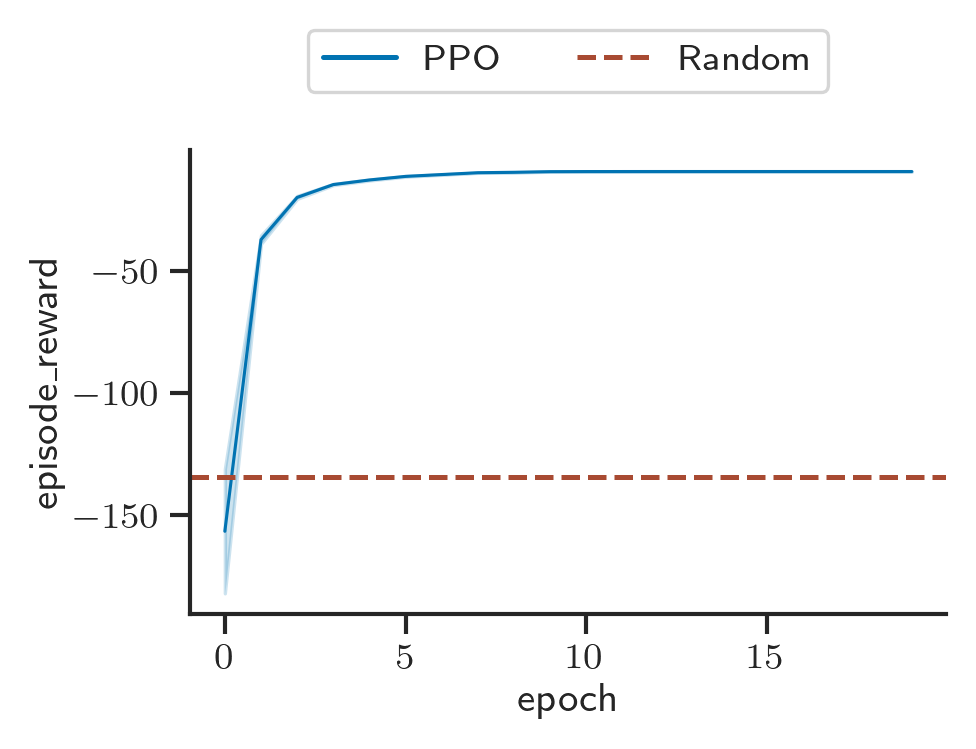

In [267]:
from ddls.plotting.plotting import plot_line

x = 'epoch'
scaling_factor = 1
metrics_to_plot = {'episode_reward', 'episode_lengths'}

for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    fig = plt.figure()
    fig = plot_line(pd.DataFrame(rl_training_stats), 
                    x=x, 
                    y=metric, 
                    hue='agent', 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
    plt.axhline(y=np.mean(random_baseline_stats[metric]), linestyle='--', color='#a84a32', label='Random')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
    plt.show()

# Rough notes

Random stuff I'm testing out how to access with `rllib`

In [220]:
print(result.keys())
print(result)

dict_keys(['episode_reward_max', 'episode_reward_min', 'episode_reward_mean', 'episode_len_mean', 'episode_media', 'episodes_this_iter', 'policy_reward_min', 'policy_reward_max', 'policy_reward_mean', 'custom_metrics', 'hist_stats', 'sampler_perf', 'off_policy_estimator', 'num_healthy_workers', 'timesteps_total', 'timesteps_this_iter', 'agent_timesteps_total', 'timers', 'info', 'done', 'episodes_total', 'training_iteration', 'trial_id', 'experiment_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'timesteps_since_restore', 'iterations_since_restore', 'perf'])
{'episode_reward_max': -1.0, 'episode_reward_min': -786.0, 'episode_reward_mean': -59.85, 'episode_len_mean': 39.73, 'episode_media': {}, 'episodes_this_iter': 0, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-7.0, -23.0, -1.0, -9.0, -31.0, -12.0, -114.0, -65.0, -248.0, -2

In [221]:
for k1 in result.keys():
    try:
        print(f'result[{k1}] keys: {result[k1].keys()}')
        for k2 in result[k1].keys():
            try:
                print(f'result[{k1}][{k2}] keys: {result[k1][k2].keys()}')
            except:
                print(f'result[{k1}][{k2}] has no keys')
    except:
        print(f'result[{k1}] has no keys')

result[episode_reward_max] has no keys
result[episode_reward_min] has no keys
result[episode_reward_mean] has no keys
result[episode_len_mean] has no keys
result[episode_media] keys: dict_keys([])
result[episodes_this_iter] has no keys
result[policy_reward_min] keys: dict_keys([])
result[policy_reward_max] keys: dict_keys([])
result[policy_reward_mean] keys: dict_keys([])
result[custom_metrics] keys: dict_keys([])
result[hist_stats] keys: dict_keys(['episode_reward', 'episode_lengths'])
result[hist_stats][episode_reward] has no keys
result[hist_stats][episode_lengths] has no keys
result[sampler_perf] keys: dict_keys(['mean_raw_obs_processing_ms', 'mean_inference_ms', 'mean_action_processing_ms', 'mean_env_wait_ms', 'mean_env_render_ms'])
result[sampler_perf][mean_raw_obs_processing_ms] has no keys
result[sampler_perf][mean_inference_ms] has no keys
result[sampler_perf][mean_action_processing_ms] has no keys
result[sampler_perf][mean_env_wait_ms] has no keys
result[sampler_perf][mean_en